

$ \frac{d\dot{m}}{dt} = \frac{A_1}{L_C}(\phi (N(t), \dot{m})P_1 - P_P(t)) $

$ \frac{d P_P}{dt} = \frac{C_1^2}{\nu _P}(\dot{m}(t) - \alpha (t) K_\nu \sqrt{P_P - P_{out}}) $

$ \begin{matrix} A_1 & = & 2.6\centerdot 10^-3 m² \\
    \nu _P & = & 2.0 m³ \\
    L_C & = & 2.0 m \\
    K_\nu & = & \frac{0.38 kg}{(10^{-5}kBar)^{0.5}s} \\
    P_1 & = & 4.5 Bar \\
    P{out} & = & 5.0 Bar \end{matrix}
$

$ \frac{d\dot{m}}{dt} = \frac{2.6\centerdot 10^{-3}}{2.0}(1.5\centerdot 4.5 - P_P) $

$ \frac{d P_P}{dt} = \frac{479.029^2}{2.0}(\dot{m} - \alpha \frac{0.38}{(10^{-5})^{0.5}} \sqrt{P_P - 5.0}) $


In [251]:
import tensorflow as tf
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.012e-01 ...  2.994e+02  3.000e+02]
        y: [[ 7.948e+01  7.948e+01 ...  7.948e+01  7.948e+01]
            [ 6.750e+00  6.750e+00 ...  6.749e+00  6.748e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 266166842
     njev: 0
      nlu: 0


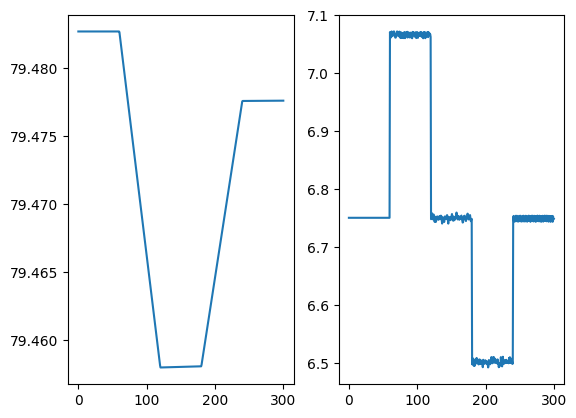

In [249]:
np.random.seed(5)
t = np.linspace(0, 300, 500)


def getAlpha(t):
    alpha = 0
    if (t < 60) or (120 <= t < 180) or (240 <= t <= 300):
        alpha = 0.5
    elif 60 <= t < 120:
        alpha = 0.46
    elif 180 <= t < 240:
        alpha = 0.54
    return alpha


def modelSys(t, x):
    m, p = x

    if (p - 5) < 0:
        p = 5

    m_t = (2.6e-3) * (1.5 * 4.5 - p) / 2
    p_t = (479e2) * (m - getAlpha(t) * (0.38 * 100 * np.sqrt(10)) * np.sqrt(p - 5)) / 2
    return [m_t, p_t]


x0 = [(19 * np.sqrt(7) * np.sqrt(10)) / 2, 27 / 4]

sol = solve_ivp(modelSys, [0, 300], x0, t_eval=t)
print(sol)
plt.subplot(1, 2, 1)
plt.plot(sol.t, sol.y[0])
plt.subplot(1, 2, 2)
plt.plot(sol.t, sol.y[1])

plt.show()

In [269]:
X_train = sol.t
y_train = tf.convert_to_tensor(sol.y)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation = "tanh"),
    tf.keras.layers.Dense(30, activation = "tanh"),
    tf.keras.layers.Dense(30, activation = "tanh"),
    tf.keras.layers.Dense(2)
])

lr = 0.01

model.compile(loss=tf.losses.mse,
              optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              metrics = ["mse"])

history = model.fit(X_train, y_train, epochs = 100, verbose = 0)

plt.plot(history.history["loss"])

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 500
'y' sizes: 2
